In [92]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib


In [93]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [94]:
# Load data
df = pd.read_csv('train-chennai-sale.csv')
df.head(5)

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,DATE_BUILD,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
0,P03210,Karapakkam,1004,04-05-2011,131,1.0,1.0,3,AbNormal,Yes,15-05-1967,Commercial,AllPub,Paved,A,4.0,3.9,4.9,4.330,380000,144400,7600000
1,P09411,Anna Nagar,1986,19-12-2006,26,2.0,1.0,5,AbNormal,No,22-12-1995,Commercial,AllPub,Gravel,RH,4.9,4.2,2.5,3.765,760122,304049,21717770
2,P01812,Adyar,909,04-02-2012,70,1.0,1.0,3,AbNormal,Yes,09-02-1992,Commercial,ELO,Gravel,RL,4.1,3.8,2.2,3.090,421094,92114,13159200
3,P05346,Velachery,1855,13-03-2010,14,3.0,2.0,5,Family,No,18-03-1988,Others,NoSewr,Paved,I,4.7,3.9,3.6,4.010,356321,77042,9630290
4,P06210,Karapakkam,1226,05-10-2009,84,1.0,1.0,3,AbNormal,Yes,13-10-1979,Others,AllPub,Gravel,C,3.0,2.5,4.1,3.290,237000,74063,7406250


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109 entries, 0 to 7108
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PRT_ID         7109 non-null   object 
 1   AREA           7109 non-null   object 
 2   INT_SQFT       7109 non-null   int64  
 3   DATE_SALE      7109 non-null   object 
 4   DIST_MAINROAD  7109 non-null   int64  
 5   N_BEDROOM      7108 non-null   float64
 6   N_BATHROOM     7104 non-null   float64
 7   N_ROOM         7109 non-null   int64  
 8   SALE_COND      7109 non-null   object 
 9   PARK_FACIL     7109 non-null   object 
 10  DATE_BUILD     7109 non-null   object 
 11  BUILDTYPE      7109 non-null   object 
 12  UTILITY_AVAIL  7109 non-null   object 
 13  STREET         7109 non-null   object 
 14  MZZONE         7109 non-null   object 
 15  QS_ROOMS       7109 non-null   float64
 16  QS_BATHROOM    7109 non-null   float64
 17  QS_BEDROOM     7109 non-null   float64
 18  QS_OVERA

#### Step 1 -- Handle mispelled names in category column

In [96]:
for column in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in '{column}':")
    print(df[column].unique())
    print("-" * 50)

Unique values in 'PRT_ID':
['P03210' 'P09411' 'P01812' ... 'P09594' 'P06508' 'P09794']
--------------------------------------------------
Unique values in 'AREA':
['Karapakkam' 'Anna Nagar' 'Adyar' 'Velachery' 'Chrompet' 'KK Nagar'
 'TNagar' 'T Nagar' 'Chrompt' 'Chrmpet' 'Karapakam' 'Ana Nagar' 'Chormpet'
 'Adyr' 'Velchery' 'Ann Nagar' 'KKNagar']
--------------------------------------------------
Unique values in 'DATE_SALE':
['04-05-2011' '19-12-2006' '04-02-2012' ... '28-03-2014' '25-08-2006'
 '13-07-2005']
--------------------------------------------------
Unique values in 'SALE_COND':
['AbNormal' 'Family' 'Partial' 'AdjLand' 'Normal Sale' 'Ab Normal'
 'Partiall' 'Adj Land' 'PartiaLl']
--------------------------------------------------
Unique values in 'PARK_FACIL':
['Yes' 'No' 'Noo']
--------------------------------------------------
Unique values in 'DATE_BUILD':
['15-05-1967' '22-12-1995' '09-02-1992' ... '01-09-1978' '11-08-1977'
 '24-07-1961']
----------------------------------

In [97]:
# Define mapping dictionaries for corrections
area_mapping = {"Ana Nagar": "Anna Nagar", "Ann Nagar": "Anna Nagar","Karapakam": "Karapakkam", "Adyr": "Adyar", "Velchery": "Velachery", "Chrompt": "Chrompet", "Chrmpet": "Chrompet", "Chormpet": "Chrompet", "KKNagar": "KK Nagar", "TNagar": "T Nagar"}

sale_cond_mapping = {"Ab Normal": "AbNormal", "Partiall": "Partial", "PartiaLl": "Partial", "Adj Land": "AdjLand"}

park_facil_mapping = {"Noo": "No"}

buildtype_mapping = {"Comercial": "Commercial", "Other": "Others"}

utility_avail_mapping = {"NoSewr ": "No sewage", "NoSeWa": "No sewage", "All Pub": "AllPub"}

street_mapping = {"Pavd": "Paved", "NoAccess": "No Access"}

# Apply mappings to respective columns
df['AREA'] = df['AREA'].replace(area_mapping)
df['SALE_COND'] = df['SALE_COND'].replace(sale_cond_mapping)
df['PARK_FACIL'] = df['PARK_FACIL'].replace(park_facil_mapping)
df['BUILDTYPE'] = df['BUILDTYPE'].replace(buildtype_mapping)
df['UTILITY_AVAIL'] = df['UTILITY_AVAIL'].replace(utility_avail_mapping)
df['STREET'] = df['STREET'].replace(street_mapping)


##### Step 2 -- Handle Datatype

In [98]:
df["DATE_SALE"]= pd.to_datetime(df["DATE_SALE"],format="%d-%m-%Y")
df["DATE_BUILD"] =  pd.to_datetime(df["DATE_BUILD"],format="%d-%m-%Y")

##### Step 3 -- Feature Engineering

In [99]:
df['AGE_OF_BUILDING'] = df["DATE_BUILD"].apply(lambda i:datetime.datetime.now().year - i.year)

In [100]:
df.drop(columns = ['PRT_ID','DATE_BUILD','DATE_SALE'],inplace=True,axis=1)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109 entries, 0 to 7108
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AREA             7109 non-null   object 
 1   INT_SQFT         7109 non-null   int64  
 2   DIST_MAINROAD    7109 non-null   int64  
 3   N_BEDROOM        7108 non-null   float64
 4   N_BATHROOM       7104 non-null   float64
 5   N_ROOM           7109 non-null   int64  
 6   SALE_COND        7109 non-null   object 
 7   PARK_FACIL       7109 non-null   object 
 8   BUILDTYPE        7109 non-null   object 
 9   UTILITY_AVAIL    7109 non-null   object 
 10  STREET           7109 non-null   object 
 11  MZZONE           7109 non-null   object 
 12  QS_ROOMS         7109 non-null   float64
 13  QS_BATHROOM      7109 non-null   float64
 14  QS_BEDROOM       7109 non-null   float64
 15  QS_OVERALL       7061 non-null   float64
 16  REG_FEE          7109 non-null   int64  
 17  COMMIS        

##### Step 4 -- Handle Duplicate

In [102]:
df_duplicate = df[df.duplicated()]
df_duplicate

,AREA,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE,AGE_OF_BUILDING


In [103]:
# There is no duplicate value present in the data

##### Step 5 -- Handle Null

In [104]:
df_null = df.isnull().sum()
df_null

AREA                0
INT_SQFT            0
DIST_MAINROAD       0
N_BEDROOM           1
N_BATHROOM          5
N_ROOM              0
SALE_COND           0
PARK_FACIL          0
BUILDTYPE           0
UTILITY_AVAIL       0
STREET              0
MZZONE              0
QS_ROOMS            0
QS_BATHROOM         0
QS_BEDROOM          0
QS_OVERALL         48
REG_FEE             0
COMMIS              0
SALES_PRICE         0
AGE_OF_BUILDING     0
dtype: int64

In [105]:
df['QS_OVERALL'] = df['QS_OVERALL'].fillna(df[['QS_ROOMS', 'QS_BATHROOM', 'QS_BEDROOM']].mean(axis=1))

In [106]:
df['N_BEDROOM'] = df['N_BEDROOM'].fillna(df['N_BEDROOM'].median())
df['N_BATHROOM'] = df['N_BATHROOM'].fillna(df['N_BATHROOM'].median())

In [107]:
df_null = df.isnull().sum()
df_null

AREA               0
INT_SQFT           0
DIST_MAINROAD      0
N_BEDROOM          0
N_BATHROOM         0
N_ROOM             0
SALE_COND          0
PARK_FACIL         0
BUILDTYPE          0
UTILITY_AVAIL      0
STREET             0
MZZONE             0
QS_ROOMS           0
QS_BATHROOM        0
QS_BEDROOM         0
QS_OVERALL         0
REG_FEE            0
COMMIS             0
SALES_PRICE        0
AGE_OF_BUILDING    0
dtype: int64

In [108]:
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['AREA', 'SALE_COND', 'PARK_FACIL', 'BUILDTYPE', 'UTILITY_AVAIL',
       'STREET', 'MZZONE'],
      dtype='object')

##### Step 6 -- Detect outliers

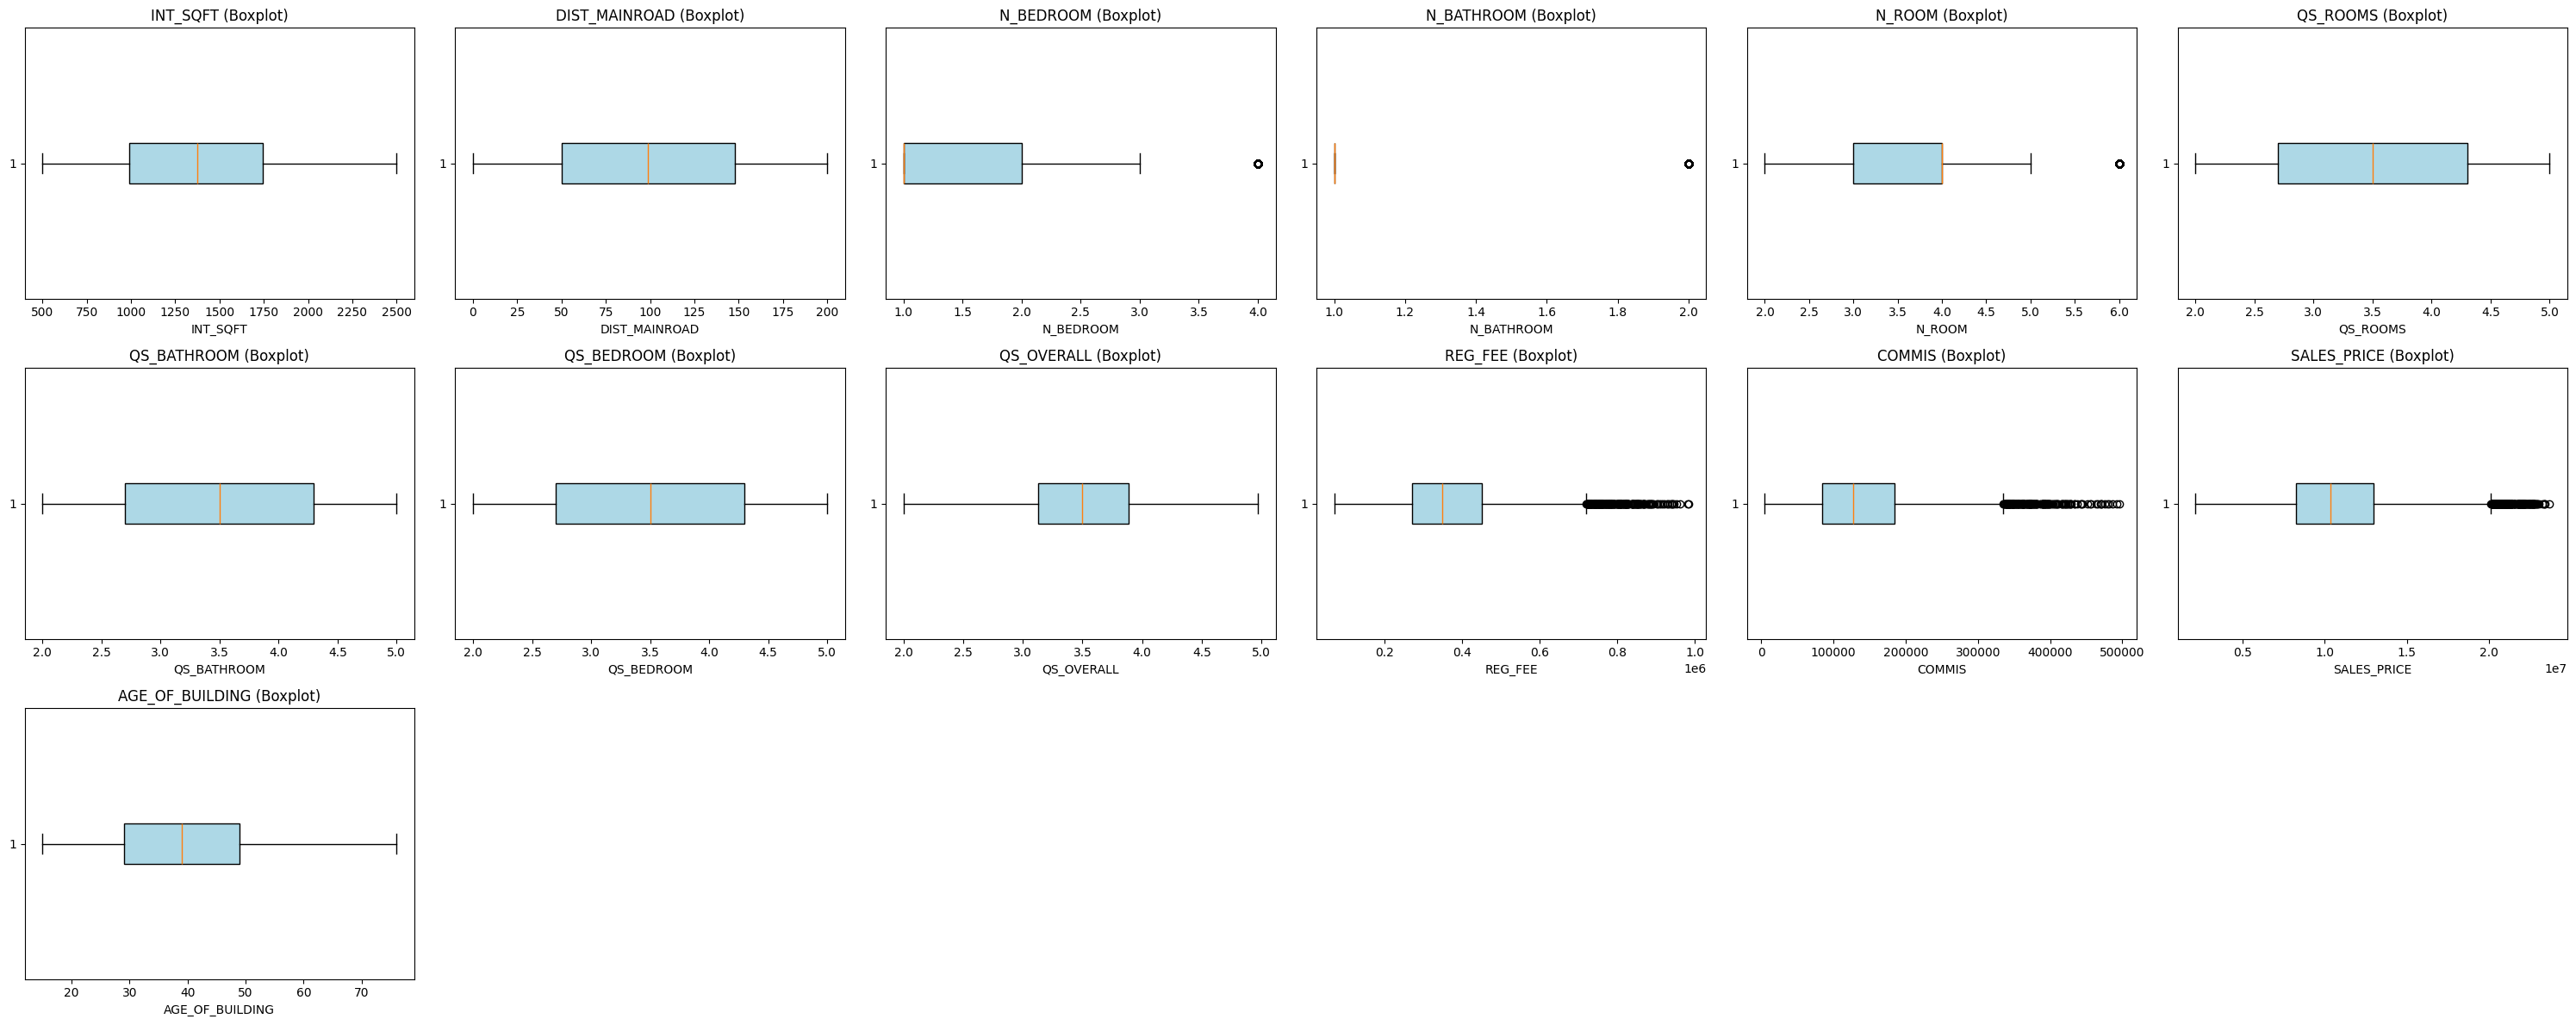

In [109]:
def visualize_outliers_boxplot(df, columns, num_cols=6):
    num_rows = (len(columns) + num_cols - 1) // num_cols 
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    axes = axes.flatten()
   
    for i, col in enumerate(columns):
        ax = axes[i]
        ax.boxplot(df[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
        ax.set_title(f"{col} (Boxplot)")
        ax.set_xlabel(col)
   
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j]) 
    plt.tight_layout()
    plt.show()
 
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
visualize_outliers_boxplot(df, numerical_cols)

In [110]:
df.to_csv('processed_data.csv', index=False)

##### Step 7 -- encode the categorical columns

In [111]:
encoder = LabelEncoder()
encoded_mappings = {}

for i in df.select_dtypes(include="object").columns:
  df[i] = encoder.fit_transform(df[i])
  encoded_mappings[i] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

for col, mapping in encoded_mappings.items():
    print(f"Encoded values for '{col}':")
    for original, encoded in mapping.items():
        print(f"  {original} -> {encoded}")
    print()

Encoded values for 'AREA':
  Adyar -> 0
  Anna Nagar -> 1
  Chrompet -> 2
  KK Nagar -> 3
  Karapakkam -> 4
  T Nagar -> 5
  Velachery -> 6

Encoded values for 'SALE_COND':
  AbNormal -> 0
  AdjLand -> 1
  Family -> 2
  Normal Sale -> 3
  Partial -> 4

Encoded values for 'PARK_FACIL':
  No -> 0
  Yes -> 1

Encoded values for 'BUILDTYPE':
  Commercial -> 0
  House -> 1
  Others -> 2

Encoded values for 'UTILITY_AVAIL':
  AllPub -> 0
  ELO -> 1
  No sewage -> 2

Encoded values for 'STREET':
  Gravel -> 0
  No Access -> 1
  Paved -> 2

Encoded values for 'MZZONE':
  A -> 0
  C -> 1
  I -> 2
  RH -> 3
  RL -> 4
  RM -> 5



##### Step 8 -- perform correation

In [112]:
correlation_matrix = df.corr()
price_correlation = correlation_matrix['SALES_PRICE'].sort_values(ascending=False)
price_correlation

SALES_PRICE        1.000000
REG_FEE            0.878148
COMMIS             0.626275
INT_SQFT           0.612125
N_ROOM             0.602760
MZZONE             0.427789
N_BEDROOM          0.330987
PARK_FACIL         0.146428
N_BATHROOM         0.108834
QS_ROOMS           0.021967
QS_OVERALL         0.020016
QS_BEDROOM         0.018804
DIST_MAINROAD      0.018783
QS_BATHROOM       -0.011377
AREA              -0.019138
UTILITY_AVAIL     -0.023812
SALE_COND         -0.030732
STREET            -0.042652
AGE_OF_BUILDING   -0.116043
BUILDTYPE         -0.436276
Name: SALES_PRICE, dtype: float64

##### Step 9 -- Split train and test data

In [113]:
X = df.drop(columns = ['SALES_PRICE'], axis=1)
y = df['SALES_PRICE']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [115]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Support Vector Regression (SVR)': SVR(),
    'K-Nearest Neighbors (KNN)': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

##### Step 10 -- Train the model with default arguments

In [116]:
# Train models and evaluate their performance
metrics = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Calculate metrics
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    
    metrics.append({
        'Model': model_name,
        'mean_absolute_error_train': mae_train,
        'R2_score_train': r2_train,
        'mean_absolute_error_test': mae_test,
        'R2_score_test': r2_test
    })

# Create a DataFrame for comparison
metrics_df = pd.DataFrame(metrics)

In [117]:
metrics_df

,Model,mean_absolute_error_train,R2_score_train,mean_absolute_error_test,R2_score_test
0,Linear Regression,1.053405e+06,0.881471,1.017013e+06,0.874688
1,Ridge Regression,1.053299e+06,0.881471,1.016906e+06,0.874686
2,Lasso Regression,1.053404e+06,0.881471,1.017012e+06,0.874688
3,ElasticNet,1.144697e+06,0.846044,1.104848e+06,0.836156
4,Support Vector Regression (SVR),2.939017e+06,-0.020507,2.802724e+06,-0.014018
5,K-Nearest Neighbors (KNN),1.168880e+06,0.842584,1.416797e+06,0.739802
6,Random Forest,1.881641e+05,0.996030,5.116982e+05,0.968019
7,Gradient Boosting,4.937914e+05,0.972056,5.500005e+05,0.961591
8,Decision Tree,0.000000e+00,1.000000,7.228803e+05,0.931461
9,XGBoost,8.358218e+04,0.999155,3.327866e+05,0.984830


In [118]:
# Identifying the best model based on R2_score
best_model_row = metrics_df.loc[metrics_df['R2_score_test'].idxmax()]
best_model_row

Model                              XGBoost
mean_absolute_error_train     83582.183533
R2_score_train                    0.999155
mean_absolute_error_test     332786.611814
R2_score_test                      0.98483
Name: 9, dtype: object

In [119]:
import sklearn
print(sklearn.__version__)

1.5.2


In [120]:
best_model = metrics_df.loc[metrics_df['R2_score_test'].idxmax(), 'Model']
best_model_Method = models[best_model]
best_model_Method 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [121]:
# Save the best model to a .pkl file
pkl_file_path = 'land_price_prediction_model.pkl'
joblib.dump(best_model_Method, pkl_file_path)

encoded_mapping_path = 'encoded_mappings.pkl'
joblib.dump(encoded_mappings, encoded_mapping_path)

['encoded_mappings.pkl']

In [122]:
df.columns

Index(['AREA', 'INT_SQFT', 'DIST_MAINROAD', 'N_BEDROOM', 'N_BATHROOM',
       'N_ROOM', 'SALE_COND', 'PARK_FACIL', 'BUILDTYPE', 'UTILITY_AVAIL',
       'STREET', 'MZZONE', 'QS_ROOMS', 'QS_BATHROOM', 'QS_BEDROOM',
       'QS_OVERALL', 'REG_FEE', 'COMMIS', 'SALES_PRICE', 'AGE_OF_BUILDING'],
      dtype='object')

In [123]:
cat_cols = ['AREA', 'SALE_COND', 'PARK_FACIL', 'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE']
unique_values = {col: df[col].unique().tolist() for col in cat_cols}
unique_values

{'AREA': [4, 1, 0, 6, 2, 3, 5],
 'SALE_COND': [0, 2, 4, 1, 3],
 'PARK_FACIL': [1, 0],
 'BUILDTYPE': [0, 2, 1],
 'UTILITY_AVAIL': [0, 1, 2],
 'STREET': [2, 0, 1],
 'MZZONE': [0, 3, 4, 2, 1, 5]}